# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
pip install tensorflow=='2.15.0'

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

2024-02-26 09:31:03.242449: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [4]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes)
    
  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x1 = self.layer1(x, activation=0)
    x2 = self.layer2(x1, activation=0)
    x3 = self.out_layer(x2, activation=1)


    return x3

In [6]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()


In [7]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [8]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)

        loss_history.append(loss)
        accuracy_history.append(acc)

        print(f"Step {step}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Step 100, Loss: 332.0947, Accuracy: 0.6641
Step 200, Loss: 240.4087, Accuracy: 0.7578
Step 300, Loss: 141.8169, Accuracy: 0.8242
Step 400, Loss: 176.2126, Accuracy: 0.8281
Step 500, Loss: 167.9548, Accuracy: 0.8281
Step 600, Loss: 115.7330, Accuracy: 0.8398
Step 700, Loss: 103.0543, Accuracy: 0.8633
Step 800, Loss: 103.4154, Accuracy: 0.9023
Step 900, Loss: 119.5522, Accuracy: 0.8359
Step 1000, Loss: 98.2156, Accuracy: 0.8984
Step 1100, Loss: 86.8324, Accuracy: 0.8945
Step 1200, Loss: 94.7412, Accuracy: 0.8672
Step 1300, Loss: 87.9118, Accuracy: 0.8672
Step 1400, Loss: 74.4206, Accuracy: 0.9414
Step 1500, Loss: 80.8692, Accuracy: 0.9062
Step 1600, Loss: 66.5087, Accuracy: 0.9102
Step 1700, Loss: 116.9916, Accuracy: 0.8984
Step 1800, Loss: 77.0348, Accuracy: 0.8906
Step 1900, Loss: 57.0473, Accuracy: 0.9375
Step 2000, Loss: 58.1735, Accuracy: 0.9336
Step 2100, Loss: 46.0060, Accuracy: 0.9609
Step 2200, Loss: 54.6399, Accuracy: 0.9297
Step 2300, Loss: 94.9169, Accuracy: 0.9023
Step 2400,

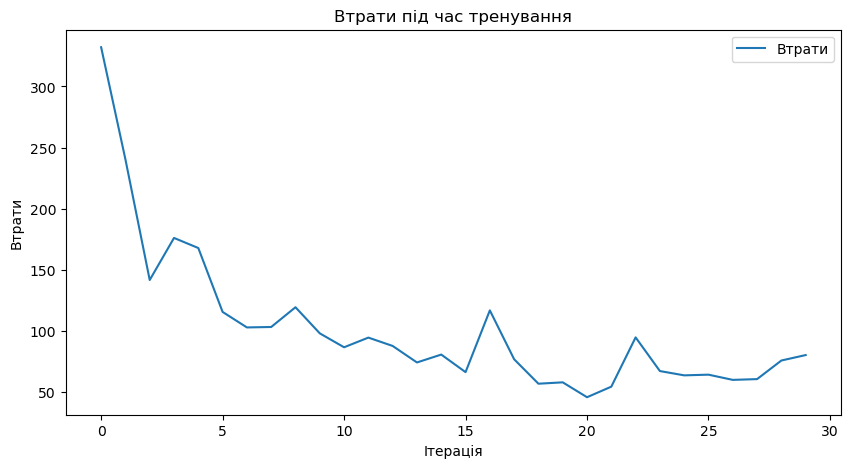

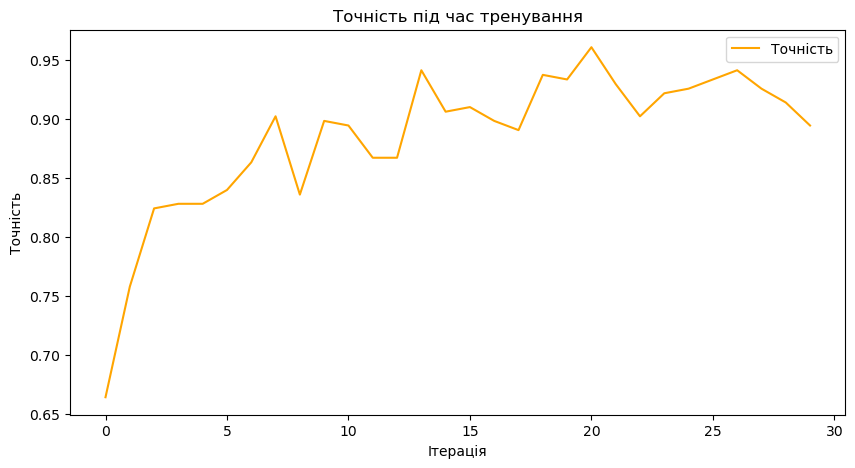

In [9]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Втрати')
plt.xlabel('Ітерація')
plt.ylabel('Втрати')
plt.title('Втрати під час тренування')
plt.legend()
plt.show()

# Виведіть графік точності
plt.figure(figsize=(10, 5))
plt.plot(accuracy_history, label='Точність', color='orange')
plt.xlabel('Ітерація')
plt.ylabel('Точність')
plt.title('Точність під час тренування')
plt.legend()
plt.show()


In [11]:
# Обчисліть точність навченої нейромережі

neural_net_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Accuracy: {neural_net_accuracy:.4f}")

Accuracy: 0.9236


True: 9 Predict: 9 True
True: 8 Predict: 8 True
True: 6 Predict: 6 True
True: 9 Predict: 9 True
True: 1 Predict: 1 True
True: 8 Predict: 8 True
True: 5 Predict: 5 True
True: 4 Predict: 4 True
True: 6 Predict: 6 True
True: 4 Predict: 4 True


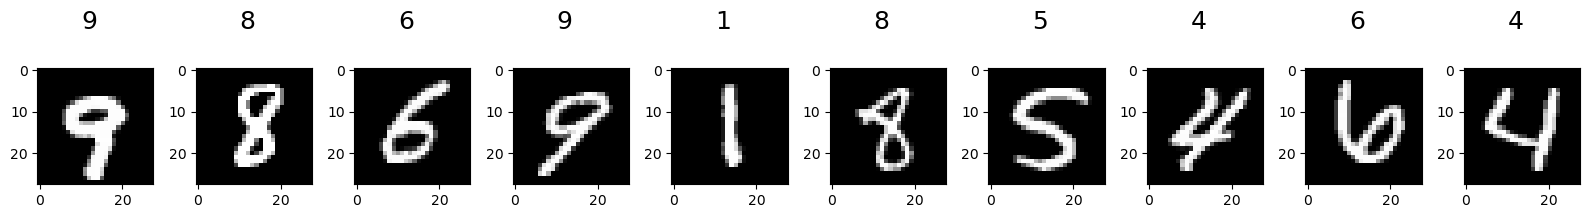

In [12]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

test_img = np.random.permutation(x_test.shape[0])[:10]
y_test_true = y_test[test_img]
pred_data = [np.argmax(x) for x in neural_net(x_test[test_img])]

plt.figure(figsize=(16, 6))
for i in range(10):
    print(f"True: {y_test_true[i]} Predict: {pred_data[i]} {True if y_test_true[i] - pred_data[i] == 0 else False}")
    plt.subplot(1, 10, (i + 1))
    plt.imshow(x_test[test_img[i]].reshape(28, 28), cmap='gray')
    plt.text(x=10, y=-10, s=pred_data[i], fontsize=18)

plt.tight_layout()
plt.show()

## Висновок: модель працює дуже непогано з точністью 92 відсотки